# **Final project:** **Modern approaches to the assessment of demand sensitivity based on uplift models and neural networks**

## This notebook is devoted to testing meta-learners

Anastasiia Kurmukova, Daria Ustinova, Evgeny Avdotin, Kundyz Onlabek

In [3]:
import numpy as np 
import pandas as pd 
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

In [4]:
# !pip -q install causalml
# !wget https://www.dropbox.com/s/w7ckhpg24qo24ao/datasets.zip?dl=0 -O datasets.zip
# !unzip -n datasets.zip
# # !pip -q install scikit-uplift
# !wget https://www.dropbox.com/s/ph0p8jqmdgnyiim/learners.zip?dl=0 -O learners.zip
# !unzip -n learners.zip

#  **Data preprocessing:X5**

In [5]:
df_x5 = pd.read_csv('retail_hero_final_model_train_data.csv', index_col='client_id')
df_features, w, y = df_x5[['first_redeem_date', 'express_spent_mean',
       'express_points_spent_sum', 'regular_points_received_sum_last_m',
       'avg_spent_perday', 'after_redeem_sum_perday']], df_x5['treatment_flg'], df_x5['target']

def x5_coding(x):
    return int(str(int(x['treatment_flg']))+str(int(x['target'])), 2)

df_x5['coding'] = df_x5.apply(x5_coding, axis=1)
c = df_x5['coding']

from sklearn.model_selection import train_test_split
indices_learn, indices_valid = train_test_split(df_x5.index, test_size=0.3,random_state=0)
X_train, w_train, y_train, c_train = df_features.loc[indices_learn].fillna(0), w.loc[indices_learn], y.loc[indices_learn], c.loc[indices_learn]
X_valid, w_valid, y_valid, c_valid = df_features.loc[indices_valid].fillna(0), w.loc[indices_valid], y.loc[indices_valid], c.loc[indices_valid]

# **Data preprocessing: Kuusisto thesis**

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def kuusisto_coding(x):
    return int(str(x['w'])+str(x['target']), 2)

def kuusisto_preprocessing(df):
    
    df = df.drop(['customer_type'],axis=1)
    df['target'] = df['outcome'].apply(lambda x: 1 if x=='positive' else 0)
    df['w'] = df['target_control'].apply(lambda x: 1 if x=='target' else 0) 
    df['coding'] = df.apply(kuusisto_coding, axis=1)  
    df = df.drop(['outcome','target_control'],axis=1)
    
    ohe = OneHotEncoder(sparse=False)
    encoded_features = pd.DataFrame(ohe.fit_transform(df[['Node1','Node2','Node3','Node4',
                                                          'Node5','Node6','Node7','Node8',
                                                          'Node9','Node10','Node11','Node12',
                                                          'Node13','Node14','Node15','Node17',
                                                          'Node18','Node19','Node20']]))
    
    df = df.drop(['Node1','Node2','Node3','Node4','Node5','Node6','Node7',
                  'Node8','Node9','Node10','Node11','Node12','Node13','Node14',
                  'Node15','Node17','Node18','Node19','Node20'],axis=1)
    
    df = pd.concat([df,encoded_features],axis=1)
    df = df.dropna()
    c = df['coding']
    y = df['target']
    w = df['w']
    X = df.drop(['target','w','coding'],axis=1)
        
    return X,y,w,c

In [7]:
df = pd.read_csv('stereotypical_customer_simulation.csv',index_col='customer_id')

# **Data preprocessing: MineThatData**


In [8]:
from sklift.datasets import fetch_hillstrom
from sklearn.preprocessing import OneHotEncoder
def mine_coding(dataset):
    return int(str(int(dataset['segment']))+str(int(dataset['visit'])), 2)

def mine_preproccessing():  
    bunch = fetch_hillstrom(target_col='visit')

    dataset, target, treatment = bunch['data'], bunch['target'], bunch['treatment']

    # Selecting two segments
    dataset = dataset[treatment!='Mens E-Mail']
    target = target[treatment!='Mens E-Mail']
    treatment = treatment[treatment!='Mens E-Mail'].map({
        'Womens E-Mail': 1,
        'No E-Mail': 0
    })
    cat_cols = dataset.select_dtypes(include='object').columns.tolist()
    ohe = OneHotEncoder(sparse=False)
    encoded_features = pd.DataFrame(ohe.fit_transform(dataset[cat_cols]))

    dataset = pd.concat([dataset,target,treatment],axis=1)
    dataset = dataset.drop(cat_cols,axis=1)
    dataset = pd.concat([dataset,encoded_features],axis=1)
    dataset = dataset.dropna()

    dataset['coding'] = dataset.apply(mine_coding, axis=1) 

    c = dataset['coding']
    y = dataset['visit'].astype(int)
    w = dataset['segment'].astype(int)
    X = dataset.drop(['visit','segment','coding'],axis=1)

    return X,y,w,c

## **Base meta learners**

In [9]:
from Slearner import Slearner
from Tlearner import Tlearner
from Xlearner import Xlearner
from Rlearner import Rlearner

from causalml.inference.meta import BaseSClassifier
from causalml.inference.meta import BaseTClassifier
from causalml.inference.meta import BaseXLearner
from causalml.inference.meta import BaseRLearner

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


Grid search for meta learners

In [10]:
import itertools
from sklearn.model_selection import ParameterGrid
from sklift.metrics import (uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift)
from sklearn.model_selection import KFold

kf = KFold(n_splits=3,random_state=1,shuffle=True)

def grid_search_one_model(learner):
    # Grid Search over 1 model for s and x learner
    
    models = [RandomForestClassifier(random_state=0,n_jobs=-1), LogisticRegression(random_state=42,n_jobs=-1),
          xgb.XGBClassifier(random_state=1,n_jobs=-1), KNeighborsClassifier(n_jobs=-1)]
    
    xgb_params = {'n_estimators':[50, 100], 'max_depth':[3,5]}
    rf_params = {'n_estimators':[50, 100], 'max_depth':[7, 11]}
    knn_params = {'n_neighbors':[10, 20, 50]}
    lr_params = {'penalty':['l2']}
    
    grid = [[RandomForestClassifier(random_state=0,n_jobs=-1),rf_params],[LogisticRegression(random_state=42,n_jobs=-1),lr_params],
            [xgb.XGBClassifier(random_state=1,n_jobs=-1),xgb_params],[KNeighborsClassifier(n_jobs=-1),knn_params]]

    best_qini_score = 0
    best_model_qini = 0
          

    for m in grid:
        
        model = m[0]
        param = m[1]
        
        
        for i in ParameterGrid(param):

            model.set_params(**i)
            qini_auc=[]
            
            for train_index, test_index in kf.split(X_train):
                X_train_split, X_test_split = X_train.loc[X_train.index[train_index]], X_train.loc[X_train.index[test_index]]
                y_train_split, y_test_split = y_train[y_train.index[train_index]], y_train[y_train.index[test_index]]
                w_train_split, w_test_split = w_train[w_train.index[train_index]], w_train[w_train.index[test_index]]

                if learner==Xlearner:
                    
                    my_lrn = learner(model)
                    my_lrn.fit(X_train_split, w_train_split, y_train_split)
                else:
                    my_lrn = learner(model)
                    my_lrn.fit(X_train_split, y_train_split, w_train_split)
                predict_lrn = my_lrn.predict(X_test_split)
                qini_auc.append(qini_auc_score(y_true= y_test_split, uplift=predict_lrn, treatment=w_test_split))
                
            if np.mean(qini_auc) > np.mean(best_qini_score):
                best_qini_score = qini_auc
                best_model_qini = model
                
            
    return best_model_qini, best_qini_score 

In [11]:
import itertools
from sklearn.model_selection import ParameterGrid
from sklift.metrics import (uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift)
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
import xgboost as xgb


kf = KFold(n_splits=3,random_state=1,shuffle=True)

def grid_search_regressor(learner):
    # Grid Search over 1 model for s and x learner
    
    models = [RandomForestRegressor(random_state=0,n_jobs=-1),SGDRegressor(random_state=42),
              xgb.XGBRegressor(random_state=1,n_jobs=-1), KNeighborsRegressor(n_jobs=-1)]
    
    xgb_params = {'n_estimators':[50, 100], 'max_depth':[3,5]}
    rf_params = {'n_estimators':[50, 100], 'max_depth':[7, 11]}
    knn_params = {'n_neighbors':[10, 20, 50]}
    lr_params = {'penalty':['l2']}
    
    grid = [[RandomForestRegressor(random_state=0,n_jobs=-1),rf_params],[SGDRegressor(random_state=42),lr_params],
            [xgb.XGBRegressor(random_state=1,n_jobs=-1),xgb_params],[KNeighborsRegressor(n_jobs=-1),knn_params]]

    best_qini_score = 0
    best_model_qini = 0
          

    for m in grid:
        
        model = m[0]
        param = m[1]
        
        
        for i in ParameterGrid(param):

            model.set_params(**i)
            qini_auc=[]
            
            for train_index, test_index in kf.split(X_train):
                X_train_split, X_test_split = X_train.loc[X_train.index[train_index]], X_train.loc[X_train.index[test_index]]
                y_train_split, y_test_split = y_train[y_train.index[train_index]], y_train[y_train.index[test_index]]
                w_train_split, w_test_split = w_train[w_train.index[train_index]], w_train[w_train.index[test_index]] 
                
                my_lrn = learner(model)
                my_lrn.fit(X_train_split, w_train_split, y_train_split)
                predict_lrn = my_lrn.predict(X_test_split)
                
                qini_auc.append(qini_auc_score(y_true= y_test_split, uplift=predict_lrn, treatment=w_test_split))
                
            if np.mean(qini_auc) > np.mean(best_qini_score):
                best_qini_score = qini_auc
                best_model_qini = model
                
            
    return best_model_qini, best_qini_score 

In [12]:
import itertools
from sklearn.model_selection import ParameterGrid
from sklift.metrics import (uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift)
from sklearn.model_selection import KFold

kf = KFold(n_splits=3,random_state=1,shuffle=True)

def grid_search_two_models(learner):
    # Grid Search over 2 models for r and t learner
    
    models = [RandomForestClassifier(random_state=0,n_jobs=-1), LogisticRegression(random_state=42,n_jobs=-1),
          xgb.XGBClassifier(random_state=1,n_jobs=-1), KNeighborsClassifier(n_jobs=-1)]
    
    xgb_params = {'n_estimators':[50, 100], 'max_depth':[3,5]}
    rf_params = {'n_estimators':[50, 100], 'max_depth':[7, 11]}
    knn_params = {'n_neighbors':[10, 20, 50]}
    lr_params = {'penalty':['l2']}
    
    grid = [[RandomForestClassifier(random_state=0,n_jobs=-1),rf_params],[LogisticRegression(random_state=42,n_jobs=-1),lr_params],
            [xgb.XGBClassifier(random_state=1,n_jobs=-1),xgb_params],[KNeighborsClassifier(n_jobs=-1),knn_params]]

    best_qini_score = 0
    #best_uplift_score = 0
    best_model1_qini = 0
    best_model2_qini = 0
    #best_model1_uplift = 0
    #best_model2_uplift = 0
        

    for m1,m2 in itertools.product(grid, repeat=2):
        
        model1 = m1[0]
        param1 = m1[1]
        
        model2 = m2[0]
        param2 = m2[1]
        
        
        for i,j in itertools.product(ParameterGrid(param1),ParameterGrid(param2)):
            model1.set_params(**i)
            model2.set_params(**j)
            qini_auc=[]
            #uplift_auc=[]
            for train_index, test_index in kf.split(X_train):
                X_train_split, X_test_split = X_train.loc[X_train.index[train_index]], X_train.loc[X_train.index[test_index]]
                y_train_split, y_test_split = y_train[y_train.index[train_index]], y_train[y_train.index[test_index]]
                w_train_split, w_test_split = w_train[w_train.index[train_index]], w_train[w_train.index[test_index]]
                c_train_split, c_test_split = c_train[c_train.index[train_index]], c_train[c_train.index[test_index]]

                if learner==Rlearner:
                    lasso = linear_model.Lasso(alpha=0.9)
                    my_lrn = learner(learner=lasso, model_w=model1, model_y=model2, n_fold=5, method='original')
                    my_lrn.fit(X_train_split, y_train_split, w_train_split, c_train_split)
                else:
                    my_lrn = learner(model1,model2)
                    my_lrn.fit(X_train_split, y_train_split, w_train_split)
                predict_lrn = my_lrn.predict(X_test_split)
                qini_auc.append(qini_auc_score(y_true= y_test_split, uplift=predict_lrn, treatment=w_test_split))
                #uplift_auc.append(uplift_auc_score(y_true= y_test_split, uplift=predict_lrn, treatment=w_test_split))
                
            if np.mean(qini_auc) > np.mean(best_qini_score):
                best_qini_score = qini_auc
                best_model1_qini = model1
                best_model2_qini = model2
                
            #if np.mean(uplift_auc) > np.mean(best_uplift_score):
             #   best_uplift_score = uplift_auc
              #  best_model1_uplift = model1
               # best_model2_uplift = model2
            
    return best_model1_qini, best_model2_qini, best_qini_score #, best_model1_uplift, best_model2_uplift, best_uplift_score

# Testing X5 dataset

In [13]:
df_features, w, y, c = x5_preprocessing(df_clients, df_train)
from sklearn.model_selection import train_test_split
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3,random_state=0)
X_train, w_train, y_train, c_train = df_features.loc[indices_learn], w.loc[indices_learn], y.loc[indices_learn], c.loc[indices_learn]
X_valid, w_valid, y_valid, c_valid = df_features.loc[indices_valid], w.loc[indices_valid], y.loc[indices_valid], c.loc[indices_valid]

NameError: name 'x5_preprocessing' is not defined

### Perform Grid Search

In [ ]:
grid_search_one_model(Slearner)

(RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0),
 [0.01937923814729761, 0.00903886439976096, 0.016576023303409106])

In [ ]:
grid_search_two_models(Tlearner)

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=1,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0),
 [0.020300382835492712, 0.016402485193383883, 0.014233310491322787])

In [ ]:
grid_search_regressor(Xlearner)

(XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              random_state=1, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None),
 [0.010035036366138712, 0.0054023836940148605, 0.010833532572853589])

In [ ]:
grid_search_two_models(Rlearner)

(RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0),
 RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0),
 [0.007262745039587083, -0.010795902694853327, 0.007312754209333113])

### Now fit models with best hyperparameters

In [ ]:
model_s = RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0)

model1_t = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
               nthread=None, objective='binary:logistic', random_state=1,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1)

model2_t = RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0)

model_x = xgb.XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=None, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              random_state=1, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

model1_r = RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0)
model2_r = LogisticRegression(random_state=42)

lasso = linear_model.Lasso(alpha=0.9)

my_slrn = Slearner(model_s)
my_tlrn = Tlearner(model1 = model1_t, model2 = model2_t)
my_xlrn = Xlearner(model_x)
my_rlrn = Rlearner(learner=lasso, model_w=model1_r, model_y=model1_r, n_fold=5, method='original')

In [ ]:
slearner = BaseSClassifier(model_s)
tlearner = BaseTClassifier(model1_t, model2_t)
xlearner = BaseXLearner(learner=model_x)
rlearner = BaseRLearner(learner=lasso, outcome_learner=model2_r,effect_learner=lasso) #this Causalml learner doesn't support RF as estimator

#### S learner

In [ ]:
# Here we perform cross validation with another! random state for more honest estimation
from sklearn.model_selection import KFold
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
# S learner fit&predict
kf = KFold(n_splits=3,random_state=2,shuffle=True)

qini_auc_s=[]
my_qini_auc_s=[]

uplift_auc_s=[]
my_uplift_auc_s=[]

uplift_s=[]
my_uplift_s=[]

for train_index, test_index in kf.split(X_train):
    my_slrn.fit(X_train.loc[X_train.index[train_index]], y_train[train_index], w_train[train_index])
    predict_my_slrn = my_slrn.predict(X_valid)

    slearner.fit(X = X_train.loc[X_train.index[train_index]], treatment = w_train[train_index], y = y_train[train_index])
    s_predict = slearner.predict(X_valid)
    s_predict = s_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_s.append(qini_auc_score(y_true=y_valid, uplift=s_predict, treatment=w_valid))
    my_qini_auc_s.append(qini_auc_score(y_true=y_valid, uplift=predict_my_slrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_s.append(uplift_auc_score(y_true=y_valid, uplift=s_predict, treatment=w_valid))
    my_uplift_auc_s.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_slrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_s.append(uplift_at_k(y_valid, uplift=predict_my_slrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_s.append(uplift_at_k(y_valid, uplift=s_predict, treatment=w_valid, strategy='overall', k=0.3))


In [ ]:
print("                           Casualml S learner:                          Our S learner:")
print(f"area under Qini curve:   {np.mean(qini_auc_s)}+-{np.std(qini_auc_s)}    {np.mean(my_qini_auc_s)}+-{np.std(my_qini_auc_s)} ")
print(f"area under uplift curve: {np.mean(uplift_auc_s)}+-{np.std(uplift_auc_s)}     {np.mean(my_uplift_auc_s)}+-{np.std(my_uplift_auc_s)}")
print(f"top 30% uplift:          {np.mean(uplift_s)}+-{np.std(uplift_s)}      {np.mean(my_uplift_s)}+-{np.std(my_uplift_s)}")

                           Casualml S learner:                          Our S learner:
area under Qini curve:   0.013423562352168022+-0.0012810823707113668    0.013979641020255765+-0.0009054187526136541 
area under uplift curve: 0.020149992157984648+-0.001997679052779442     0.020974974224739453+-0.0014326345277983499
top 30% uplift:          0.0654503017460442+-0.001195990380531132      0.06550804095463574+-0.001621950928349823


#### T learner

In [ ]:
qini_auc_t=[]
my_qini_auc_t=[]

uplift_auc_t=[]
my_uplift_auc_t=[]

uplift_t=[]
my_uplift_t=[]

for train_index, test_index in kf.split(X_train):

    my_tlrn.fit(X_train.loc[X_train.index[train_index]], y_train[train_index], w_train[train_index])
    predict_my_tlrn = my_tlrn.predict(X_valid)

    tlearner.fit(X = X_train.loc[X_train.index[train_index]], treatment = w_train[train_index], y = y_train[train_index])
    t_predict = tlearner.predict(X_valid.values)
    t_predict = t_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_t.append(qini_auc_score(y_true=y_valid, uplift=t_predict, treatment=w_valid))
    my_qini_auc_t.append(qini_auc_score(y_true=y_valid, uplift=predict_my_tlrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_t.append(uplift_auc_score(y_true=y_valid, uplift=t_predict, treatment=w_valid))
    my_uplift_auc_t.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_tlrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_t.append(uplift_at_k(y_valid, uplift=predict_my_tlrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_t.append(uplift_at_k(y_valid, uplift=t_predict, treatment=w_valid, strategy='overall', k=0.3))

In [ ]:
print("                           Casualml T learner:                          Our T learner:")
print(f"area under Qini curve:   {np.mean(qini_auc_t)}+-{np.std(qini_auc_t)}    {np.mean(my_qini_auc_t)}+-{np.std(my_qini_auc_t)} ")
print(f"area under uplift curve: {np.mean(uplift_auc_t)}+-{np.std(uplift_auc_t)}    {np.mean(my_uplift_auc_t)}+-{np.std(my_uplift_auc_t)}")
print(f"top 30% uplift:          {np.mean(uplift_t)}+-{np.std(uplift_t)}    {np.mean(my_uplift_t)}+-{np.std(my_uplift_t)}")

                           Casualml T learner:                          Our T learner:
area under Qini curve:   0.014886445666733188+-0.0026751523513384337    0.014886445492025066+-0.0026751524833133456 
area under uplift curve: 0.021713787968941727+-0.004173225383498756    0.02171378780509511+-0.004173225511643082
top 30% uplift:          0.06690862363803647+-0.0054149460266046615    0.06690862363803647+-0.0054149460266046615


#### X learner

In [ ]:
qini_auc_x=[]
my_qini_auc_x=[]

uplift_auc_x=[]
my_uplift_auc_x=[]

uplift_x=[]
my_uplift_x=[]

for train_index, test_index in kf.split(X_train):

    my_xlrn.fit(X_train.loc[X_train.index[train_index]], w_train[train_index], y_train[train_index])
    predict_my_xlrn = my_xlrn.predict(X_valid)

    xlearner.fit(X = X_train.loc[X_train.index[train_index]], treatment = w_train[train_index], y = y_train[train_index])
    x_predict = xlearner.predict(X_valid)
    x_predict = x_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_x.append(qini_auc_score(y_true=y_valid, uplift=x_predict, treatment=w_valid))
    my_qini_auc_x.append(qini_auc_score(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_x.append(uplift_auc_score(y_true=y_valid, uplift=x_predict, treatment=w_valid))
    my_uplift_auc_x.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_x.append(uplift_at_k(y_valid, uplift=predict_my_xlrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_x.append(uplift_at_k(y_valid, uplift=x_predict, treatment=w_valid, strategy='overall', k=0.3))

In [ ]:
print("                           Casualml X learner:                          Our X learner:")
print(f"area under Qini curve:   {np.mean(qini_auc_x)}+-{np.std(qini_auc_x)}    {np.mean(my_qini_auc_x)}+-{np.std(my_qini_auc_x)} ")
print(f"area under uplift curve: {np.mean(uplift_auc_x)}+-{np.std(uplift_auc_x)}    {np.mean(my_uplift_auc_x)}+-{np.std(my_uplift_auc_x)}")
print(f"top 30% uplift:          {np.mean(uplift_x)}+-{np.std(uplift_x)}    {np.mean(my_uplift_x)}+-{np.std(my_uplift_x)}")

                           Casualml X learner:                          Our X learner:
area under Qini curve:   0.0077859935103787+-0.0011775964070769036    0.005246069644557742+-0.0007695456587054018 
area under uplift curve: 0.011984911482091881+-0.0018131100592031174    0.00821668581068855+-0.0011634647507143753
top 30% uplift:          0.05370334239476249+-0.0008931976262999416    0.04893771276832448+-0.0027734294848335258


In [ ]:
qini_auc_x=[]
my_qini_auc_x=[]

uplift_auc_x=[]
my_uplift_auc_x=[]

uplift_x=[]
my_uplift_x=[]

for train_index, test_index in kf.split(X_train):

    my_xlrn.fit(X_train.loc[X_train.index[train_index]], w_train[train_index], y_train[train_index])
    predict_my_xlrn = my_xlrn.predict(X_valid)

    xlearner.fit(X = X_train.loc[X_train.index[train_index]], treatment = w_train[train_index], y = y_train[train_index])
    x_predict = xlearner.predict(X_valid)
    x_predict = x_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_x.append(qini_auc_score(y_true=y_valid, uplift=x_predict, treatment=w_valid))
    my_qini_auc_x.append(qini_auc_score(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_x.append(uplift_auc_score(y_true=y_valid, uplift=x_predict, treatment=w_valid))
    my_uplift_auc_x.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_x.append(uplift_at_k(y_valid, uplift=predict_my_xlrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_x.append(uplift_at_k(y_valid, uplift=x_predict, treatment=w_valid, strategy='overall', k=0.3))

In [ ]:
print("                           Casualml X learner:                          Our X learner:")
print(f"area under Qini curve:   {np.mean(qini_auc_x)}+-{np.std(qini_auc_x)}    {np.mean(my_qini_auc_x)}+-{np.std(my_qini_auc_x)} ")
print(f"area under uplift curve: {np.mean(uplift_auc_x)}+-{np.std(uplift_auc_x)}    {np.mean(my_uplift_auc_x)}+-{np.std(my_uplift_auc_x)}")
print(f"top 30% uplift:          {np.mean(uplift_x)}+-{np.std(uplift_x)}    {np.mean(my_uplift_x)}+-{np.std(my_uplift_x)}")

                           Casualml X learner:                          Our X learner:
area under Qini curve:   0.010087220075061977+-0.0021204809357584474    0.006454550369415116+-0.002834518342546574 
area under uplift curve: 0.014942761297395158+-0.002935148757381129    0.009711943706613943+-0.004187627417383485
top 30% uplift:          0.051229802677614455+-0.008018466880979612    0.04864629917024732+-0.0036436310170517637


#### R learner

In [ ]:
from sklearn.model_selection import KFold
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
qini_auc_r=[]
my_qini_auc_r=[]

uplift_auc_r=[]
my_uplift_auc_r=[]

uplift_r=[]
my_uplift_r=[]

for train_index, test_index in kf.split(X_train):

    my_rlrn.fit(X_train.loc[X_train.index[train_index]], y_train[train_index], w_train[train_index],c_train[train_index])
    predict_my_rlrn = my_rlrn.predict(X_valid)

    rlearner.fit(X = X_train.loc[X_train.index[train_index]], treatment = w_train[train_index].astype(int), y = y_train[train_index].astype(int))
    r_predict = rlearner.predict(X_valid)
    r_predict = r_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_r.append(qini_auc_score(y_true=y_valid, uplift=r_predict, treatment=w_valid))
    my_qini_auc_r.append(qini_auc_score(y_true=y_valid, uplift=predict_my_rlrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_r.append(uplift_auc_score(y_true=y_valid, uplift=r_predict, treatment=w_valid))
    my_uplift_auc_r.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_rlrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_r.append(uplift_at_k(y_valid, uplift=predict_my_rlrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_r.append(uplift_at_k(y_valid, uplift=r_predict, treatment=w_valid, strategy='overall', k=0.3))

In [ ]:
print("                           Casualml R learner:                          Our R learner:")
print(f"area under Qini curve:   {np.mean(qini_auc_r)}+-{np.std(qini_auc_r)}    {np.mean(my_qini_auc_r)}+-{np.std(my_qini_auc_r)} ")
print(f"area under uplift curve: {np.mean(uplift_auc_r)}+-{np.std(uplift_auc_r)}    {np.mean(my_uplift_auc_r)}+-{np.std(my_uplift_auc_r)}")
print(f"top 30% uplift:          {np.mean(uplift_r)}+-{np.std(uplift_r)}    {np.mean(my_uplift_r)}+-{np.std(my_uplift_r)}")

                           Casualml R learner:                          Our R learner:
area under Qini curve:   0.0007525614509349268+-0.000532141305215674    0.0011288421764023902+-0.0 
area under uplift curve: 0.0011968623617225134+-0.0008463094921209357    0.0017952935425837701+-0.0
top 30% uplift:          0.03975775829516307+-0.0010483008224878945    0.0404990189154677+-0.0


Explore some qini and uplift curves

<AxesSubplot:title={'center':'Uplift curve\nuplift_auc_score=0.0226'}, xlabel='Number targeted', ylabel='Gain: treatment - control'>

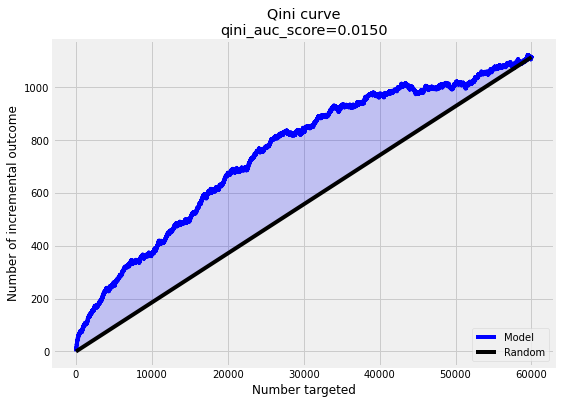

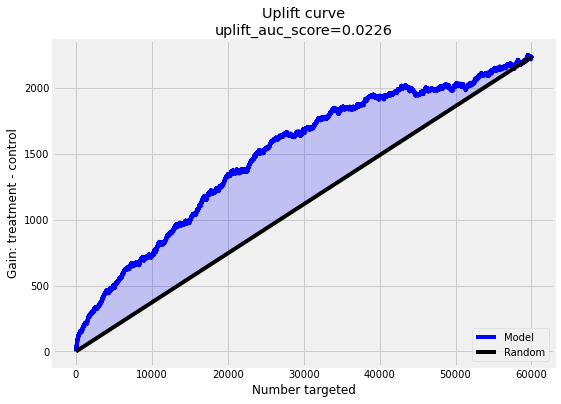

In [ ]:
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
# S learner
plot_qini_curve(y_true=y_valid, uplift=predict_my_slrn, treatment=w_valid, perfect=False)
plot_uplift_curve(y_true=y_valid, uplift=predict_my_slrn, treatment=w_valid, perfect=False)

<AxesSubplot:title={'center':'Uplift curve\nuplift_auc_score=0.0184'}, xlabel='Number targeted', ylabel='Gain: treatment - control'>

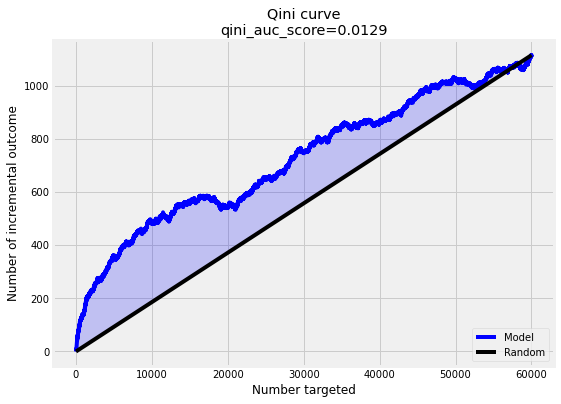

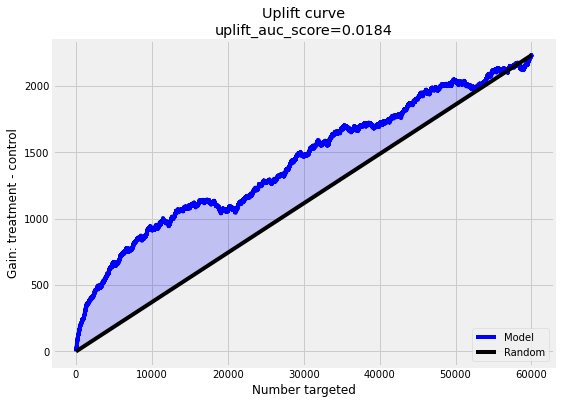

In [ ]:
# T learner
plot_qini_curve(y_true=y_valid, uplift=predict_my_tlrn, treatment=w_valid, perfect=False)
plot_uplift_curve(y_true=y_valid, uplift=predict_my_tlrn, treatment=w_valid, perfect=False)

<AxesSubplot:title={'center':'Uplift curve\nuplift_auc_score=0.0018'}, xlabel='Number targeted', ylabel='Gain: treatment - control'>

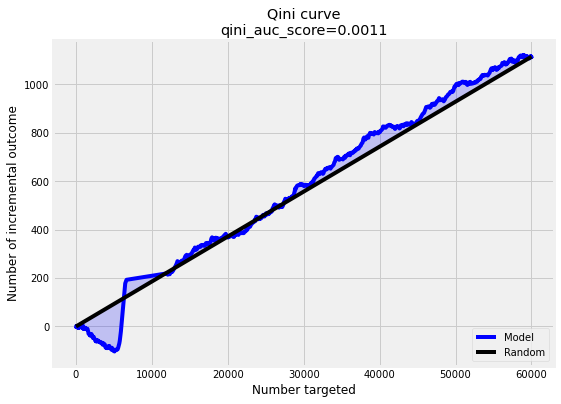

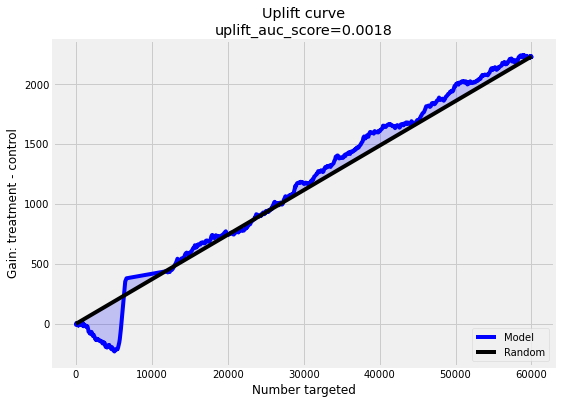

In [ ]:
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
# R learner
plot_qini_curve(y_true=y_valid, uplift=predict_my_rlrn, treatment=w_valid, perfect=False)
plot_uplift_curve(y_true=y_valid, uplift=predict_my_rlrn, treatment=w_valid, perfect=False)

# **Testing Kuusisto's synthetic dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving stereotypical_customer_simulation.csv to stereotypical_customer_simulation.csv


In [ ]:
df = pd.read_csv('stereotypical_customer_simulation.csv',index_col='customer_id')
X, y, w, c  = kuusisto_preprocessing(df)
from sklearn.model_selection import train_test_split
indices_learn, indices_valid = train_test_split(X.index, test_size=0.3,random_state=0)
X_train, w_train, y_train, c_train = X.loc[indices_learn], w.loc[indices_learn], y.loc[indices_learn], c.loc[indices_learn]
X_valid, w_valid, y_valid, c_valid = X.loc[indices_valid], w.loc[indices_valid], y.loc[indices_valid], c.loc[indices_valid]

### Firstly, let's use grid search for estimating best hyperparameters

In [ ]:
grid_search_one_model(Slearner)

(LogisticRegression(n_jobs=-1, random_state=42),
 [0.005279602349535454, 0.05447403241619288, -0.017337436098555047])

In [ ]:
grid_search_two_models(Tlearner)

(RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=1,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 [0.014837992381087774, 0.0093330166835336, 0.03219588327307349])

In [ ]:
grid_search_regressor(Xlearner)

(XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              random_state=1, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None),
 [0.024924444012141313, -0.0008312311260743814, 0.034018326853774636])

In [ ]:
grid_search_two_models(Rlearner)

(0, 0, 0)

We can see, that in this dataset Rlearner performs negative qini auc score, i.e. it's not effective. But to compare it with causalml one we can use previous grid search estimations

### Now fit models with best hyperparameters

In [ ]:
model_s = LogisticRegression(n_jobs=-1, random_state=42)

model1_t = RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0)

model2_t = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=None, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=1,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)

model_x = xgb.XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=None, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              random_state=1, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

model1_r = RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0)
model2_r = LogisticRegression(random_state=42)

lasso = linear_model.Lasso(alpha=0.9)

my_slrn = Slearner(model_s)
my_tlrn = Tlearner(model1 = model1_t, model2 = model2_t)
my_xlrn = Xlearner(model_x)
my_rlrn = Rlearner(learner=lasso, model_w=model1_r, model_y=model1_r, n_fold=5, method='original')

In [ ]:
slearner = BaseSClassifier(model_s)
tlearner = BaseTClassifier(model1_t, model2_t)
xlearner = BaseXLearner(learner=model_x)
rlearner = BaseRLearner(learner=lasso, outcome_learner=model2_r,effect_learner=lasso)

#### S learner

In [ ]:
# Here we perform cross validation with another! random state for more honest estimation
from sklearn.model_selection import KFold
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
# S learner fit&predict
kf = KFold(n_splits=3,random_state=2,shuffle=True)

qini_auc_s=[]
my_qini_auc_s=[]

uplift_auc_s=[]
my_uplift_auc_s=[]

uplift_s=[]
my_uplift_s=[]

for train_index, test_index in kf.split(X_train):

    my_slrn.fit(X_train.loc[X_train.index[train_index]], y_train.loc[y_train.index[train_index]], w_train.loc[w_train.index[train_index]])
    predict_my_slrn = my_slrn.predict(X_valid)

    slearner.fit(X = X_train.loc[X_train.index[train_index]], treatment = w_train.loc[w_train.index[train_index]], y = y_train.loc[y_train.index[train_index]])
    s_predict = slearner.predict(X_valid)
    s_predict = s_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_s.append(qini_auc_score(y_true=y_valid, uplift=s_predict, treatment=w_valid))
    my_qini_auc_s.append(qini_auc_score(y_true=y_valid, uplift=predict_my_slrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_s.append(uplift_auc_score(y_true=y_valid, uplift=s_predict, treatment=w_valid))
    my_uplift_auc_s.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_slrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_s.append(uplift_at_k(y_valid, uplift=predict_my_slrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_s.append(uplift_at_k(y_valid, uplift=s_predict, treatment=w_valid, strategy='overall', k=0.3))

In [ ]:
print("                           Casualml S learner:                          Our S learner:")
print(f"area under Qini curve:   {np.mean(qini_auc_s)}+-{np.std(qini_auc_s)}    {np.mean(my_qini_auc_s)}+-{np.std(my_qini_auc_s)} ")
print(f"area under uplift curve: {np.mean(uplift_auc_s)}+-{np.std(uplift_auc_s)}     {np.mean(my_uplift_auc_s)}+-{np.std(my_uplift_auc_s)}")
print(f"top 30% uplift:          {np.mean(uplift_s)}+-{np.std(uplift_s)}      {np.mean(my_uplift_s)}+-{np.std(my_uplift_s)}")

                           Casualml S learner:                          Our S learner:
area under Qini curve:   -0.002033129938737346+-0.006360332110567717    -0.002033129938737346+-0.006360332110567717 
area under uplift curve: -0.0027110617573155734+-0.00835890665454927     -0.0027110617573155734+-0.00835890665454927
top 30% uplift:          0.005229932671511302+-0.019024446536499876      0.005229932671511302+-0.019024446536499876


#### T learner

In [ ]:
qini_auc_t=[]
my_qini_auc_t=[]

uplift_auc_t=[]
my_uplift_auc_t=[]

uplift_t=[]
my_uplift_t=[]

for train_index, test_index in kf.split(X_train):

    my_tlrn.fit(X_train.loc[X_train.index[train_index]], y_train.loc[y_train.index[train_index]],w_train.loc[w_train.index[train_index]])
    predict_my_tlrn = my_tlrn.predict(X_valid)

    tlearner.fit(X = X_train.loc[X_train.index[train_index]], treatment = w_train.loc[w_train.index[train_index]], y = y_train.loc[y_train.index[train_index]])
    t_predict = tlearner.predict(X_valid.values)
    t_predict = t_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_t.append(qini_auc_score(y_true=y_valid, uplift=t_predict, treatment=w_valid))
    my_qini_auc_t.append(qini_auc_score(y_true=y_valid, uplift=predict_my_tlrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_t.append(uplift_auc_score(y_true=y_valid, uplift=t_predict, treatment=w_valid))
    my_uplift_auc_t.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_tlrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_t.append(uplift_at_k(y_valid, uplift=predict_my_tlrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_t.append(uplift_at_k(y_valid, uplift=t_predict, treatment=w_valid, strategy='overall', k=0.3))

In [ ]:
print("                           Casualml T learner:                          Our T learner:")
print(f"area under Qini curve:   {np.mean(qini_auc_t)}+-{np.std(qini_auc_t)}    {np.mean(my_qini_auc_t)}+-{np.std(my_qini_auc_t)} ")
print(f"area under uplift curve: {np.mean(uplift_auc_t)}+-{np.std(uplift_auc_t)}    {np.mean(my_uplift_auc_t)}+-{np.std(my_uplift_auc_t)}")
print(f"top 30% uplift:          {np.mean(uplift_t)}+-{np.std(uplift_t)}    {np.mean(my_uplift_t)}+-{np.std(my_uplift_t)}")

                           Casualml T learner:                          Our T learner:
area under Qini curve:   -0.012259259005468181+-0.01093452899723124    -0.012259259005468181+-0.01093452899723124 
area under uplift curve: -0.01665775458338135+-0.014661468648812794    -0.01665775458338135+-0.014661468648812794
top 30% uplift:          0.009410601555479644+-0.006556095217945135    0.009410601555479644+-0.006556095217945135


#### X learner

In [ ]:
qini_auc_x=[]
my_qini_auc_x=[]

uplift_auc_x=[]
my_uplift_auc_x=[]

uplift_x=[]
my_uplift_x=[]

for train_index, test_index in kf.split(X_train):

    my_xlrn.fit(X_train.loc[X_train.index[train_index]], y_train.loc[y_train.index[train_index]],w_train.loc[w_train.index[train_index]])
    predict_my_xlrn = my_xlrn.predict(X_valid)

    xlearner.fit(X = X_train.loc[X_train.index[train_index]], treatment = w_train.loc[w_train.index[train_index]], y = y_train.loc[y_train.index[train_index]])
    x_predict = xlearner.predict(X_valid.values)
    x_predict = x_predict.reshape(1, -1)[0]

    # Area under qini curve
    #qini_auc_t.append(qini_auc_score(y_true=y_valid, uplift=x_predict, treatment=w_valid))
    #my_qini_auc_t.append(qini_auc_score(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_x.append(uplift_auc_score(y_true=y_valid, uplift=x_predict, treatment=w_valid))
    my_uplift_auc_x.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_x.append(uplift_at_k(y_valid, uplift=predict_my_xlrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_x.append(uplift_at_k(y_valid, uplift=x_predict, treatment=w_valid, strategy='overall', k=0.3))

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


In [ ]:
print("                           Casualml X learner:                          Our X learner:")
#print(f"area under Qini curve:   {np.mean(qini_auc_x)}+-{np.std(qini_auc_x)}    {np.mean(my_qini_auc_x)}+-{np.std(my_qini_auc_x)} ")
print(f"area under uplift curve: {np.mean(uplift_auc_x)}+-{np.std(uplift_auc_x)}    {np.mean(my_uplift_auc_x)}+-{np.std(my_uplift_auc_x)}")
print(f"top 30% uplift:          {np.mean(uplift_x)}+-{np.std(uplift_x)}    {np.mean(my_uplift_x)}+-{np.std(my_uplift_x)}")

                           Casualml X learner:                          Our X learner:
area under uplift curve: -0.013322642634245768+-0.016222665506834662    0.0018682574265868465+-0.014159582417823379
top 30% uplift:          0.009143673037643222+-0.02180549627679998    0.028604086234250186+-0.005709720825964861


#### R learner

In [ ]:
from sklearn.model_selection import KFold
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
qini_auc_r=[]
my_qini_auc_r=[]

uplift_auc_r=[]
my_uplift_auc_r=[]

uplift_r=[]
my_uplift_r=[]

for train_index, test_index in kf.split(X_train):

    my_rlrn.fit(X_train.loc[X_train.index[train_index]], y_train.loc[y_train.index[train_index]],w_train.loc[w_train.index[train_index]],c_train.loc[c_train.index[train_index]])
    predict_my_rlrn = my_rlrn.predict(X_valid)

    rlearner.fit(X_train.loc[X_train.index[train_index]], y_train.loc[y_train.index[train_index]],w_train.loc[w_train.index[train_index]])
    r_predict = rlearner.predict(X_valid)
    r_predict = r_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_r.append(qini_auc_score(y_true=y_valid, uplift=r_predict, treatment=w_valid))
    my_qini_auc_r.append(qini_auc_score(y_true=y_valid, uplift=predict_my_rlrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_r.append(uplift_auc_score(y_true=y_valid, uplift=r_predict, treatment=w_valid))
    my_uplift_auc_r.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_rlrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_r.append(uplift_at_k(y_valid, uplift=predict_my_rlrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_r.append(uplift_at_k(y_valid, uplift=r_predict, treatment=w_valid, strategy='overall', k=0.3))

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


In [ ]:
print("                           Casualml R learner:                          Our R learner:")
#print(f"area under Qini curve:   {np.mean(qini_auc_r)}+-{np.std(qini_auc_r)}    {np.mean(my_qini_auc_r)}+-{np.std(my_qini_auc_r)} ")
#print(f"area under uplift curve: {np.mean(uplift_auc_r)}+-{np.std(uplift_auc_r)}    {np.mean(my_uplift_auc_r)}+-{np.std(my_uplift_auc_r)}")
print(f"top 30% uplift:          {np.mean(uplift_r)}+-{np.std(uplift_r)}    {np.mean(my_uplift_r)}+-{np.std(my_uplift_r)}")

                           Casualml R learner:                          Our R learner:
top 30% uplift:          0.012093726379440728+-0.0    0.012093726379440728+-0.0


Now let's plot some curves

<AxesSubplot:title={'center':'Uplift curve\nuplift_auc_score=0.0031'}, xlabel='Number targeted', ylabel='Gain: treatment - control'>

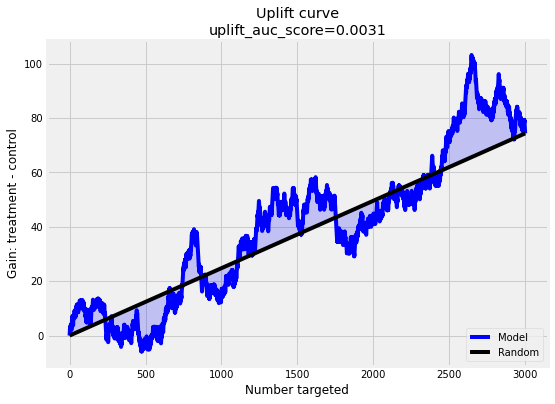

In [ ]:
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
# X learner
plot_uplift_curve(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid, perfect=False)

In [ ]:
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
# X learner
plot_qini_curve(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid, perfect=False)
plot_uplift_curve(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid, perfect=False)

# **Testing MineThatData dataset**

In [ ]:
X,y,w,c = mine_preproccessing()

In [ ]:
from sklearn.model_selection import train_test_split
indices_learn, indices_valid = train_test_split(X.index, test_size=0.3,random_state=0)
X_train, w_train, y_train, c_train = X.loc[indices_learn], w.loc[indices_learn], y.loc[indices_learn], c.loc[indices_learn]
X_valid, w_valid, y_valid, c_valid = X.loc[indices_valid], w.loc[indices_valid], y.loc[indices_valid], c.loc[indices_valid]

Firstly, perform Grid Search

In [ ]:
grid_search_one_model(Slearner)

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=1,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 [0.053470769198401595, 0.08442493872155207, 0.058485756120191655])

In [ ]:
grid_search_two_models(Tlearner)

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=1,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0),
 [0.05453542966944058, 0.06723585378149473, 0.05941860678723207])

In [ ]:
grid_search_regressor(Xlearner)

(RandomForestRegressor(max_depth=11, n_jobs=-1, random_state=0),
 [0.0655121394203221, 0.06163814077716754, 0.050177205597450994])

In [ ]:
grid_search_two_models(Rlearner)

(0, 0, 0)

Now fit and predict our models with best hyperparameters

In [ ]:
model_s = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=None, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=1,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)

model1_t = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=None, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=1,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)

model2_t = RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0)

model_x = RandomForestRegressor(max_depth=11, n_jobs=-1, random_state=0)

model1_r = RandomForestClassifier(max_depth=11, n_jobs=-1, random_state=0)
model2_r = LogisticRegression(random_state=42)

lasso = linear_model.Lasso(alpha=0.9)

my_slrn = Slearner(model_s)
my_tlrn = Tlearner(model1 = model1_t, model2 = model2_t)
my_xlrn = Xlearner(model_x)
my_rlrn = Rlearner(learner=lasso, model_w=model1_r, model_y=model1_r, n_fold=5, method='original')

In [ ]:
slearner = BaseSClassifier(model_s)
tlearner = BaseTClassifier(model1_t, model2_t)
xlearner = BaseXLearner(learner=model_x)
rlearner = BaseRLearner(learner=lasso, outcome_learner=model2_r,effect_learner=lasso)

In [ ]:
# Here we perform cross validation with another! random state for more honest estimation
from sklearn.model_selection import KFold
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
# S learner fit&predict
kf = KFold(n_splits=3,random_state=2,shuffle=True)

qini_auc_s=[]
my_qini_auc_s=[]

uplift_auc_s=[]
my_uplift_auc_s=[]

uplift_s=[]
my_uplift_s=[]

for train_index, test_index in kf.split(X_train):

    my_slrn.fit(X_train.loc[X_train.index[train_index]], y_train.loc[y_train.index[train_index]], w_train.loc[w_train.index[train_index]])
    predict_my_slrn = my_slrn.predict(X_valid)

    slearner.fit(X = X_train.loc[X_train.index[train_index]], treatment = w_train.loc[w_train.index[train_index]], y = y_train.loc[y_train.index[train_index]])
    s_predict = slearner.predict(X_valid)
    s_predict = s_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_s.append(qini_auc_score(y_true=y_valid, uplift=s_predict, treatment=w_valid))
    my_qini_auc_s.append(qini_auc_score(y_true=y_valid, uplift=predict_my_slrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_s.append(uplift_auc_score(y_true=y_valid, uplift=s_predict, treatment=w_valid))
    my_uplift_auc_s.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_slrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_s.append(uplift_at_k(y_valid, uplift=predict_my_slrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_s.append(uplift_at_k(y_valid, uplift=s_predict, treatment=w_valid, strategy='overall', k=0.3))

In [ ]:
print("                           Casualml S learner:                          Our S learner:")
print(f"area under Qini curve:   {np.mean(qini_auc_s)}+-{np.std(qini_auc_s)}    {np.mean(my_qini_auc_s)}+-{np.std(my_qini_auc_s)} ")
print(f"area under uplift curve: {np.mean(uplift_auc_s)}+-{np.std(uplift_auc_s)}     {np.mean(my_uplift_auc_s)}+-{np.std(my_uplift_auc_s)}")
print(f"top 30% uplift:          {np.mean(uplift_s)}+-{np.std(uplift_s)}      {np.mean(my_uplift_s)}+-{np.std(my_uplift_s)}")

                           Casualml S learner:                          Our S learner:
area under Qini curve:   0.03177061532543405+-0.004942785707468644    0.03177061532543405+-0.004942785707468644 
area under uplift curve: 0.014160351054217106+-0.0020282972401776777     0.014160351054217106+-0.0020282972401776777
top 30% uplift:          0.07688636393645681+-0.005038496232177422      0.07688636393645681+-0.005038496232177422


In [ ]:
qini_auc_t=[]
my_qini_auc_t=[]

uplift_auc_t=[]
my_uplift_auc_t=[]

uplift_t=[]
my_uplift_t=[]

for train_index, test_index in kf.split(X_train):

    my_tlrn.fit(X_train.loc[X_train.index[train_index]], y_train.loc[y_train.index[train_index]],w_train.loc[w_train.index[train_index]])
    predict_my_tlrn = my_tlrn.predict(X_valid)

    tlearner.fit(X = X_train.loc[X_train.index[train_index]], treatment = w_train.loc[w_train.index[train_index]], y = y_train.loc[y_train.index[train_index]])
    t_predict = tlearner.predict(X_valid.values)
    t_predict = t_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_t.append(qini_auc_score(y_true=y_valid, uplift=t_predict, treatment=w_valid))
    my_qini_auc_t.append(qini_auc_score(y_true=y_valid, uplift=predict_my_tlrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_t.append(uplift_auc_score(y_true=y_valid, uplift=t_predict, treatment=w_valid))
    my_uplift_auc_t.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_tlrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_t.append(uplift_at_k(y_valid, uplift=predict_my_tlrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_t.append(uplift_at_k(y_valid, uplift=t_predict, treatment=w_valid, strategy='overall', k=0.3))

In [ ]:
print("                           Casualml T learner:                          Our T learner:")
print(f"area under Qini curve:   {np.mean(qini_auc_t)}+-{np.std(qini_auc_t)}    {np.mean(my_qini_auc_t)}+-{np.std(my_qini_auc_t)} ")
print(f"area under uplift curve: {np.mean(uplift_auc_t)}+-{np.std(uplift_auc_t)}    {np.mean(my_uplift_auc_t)}+-{np.std(my_uplift_auc_t)}")
print(f"top 30% uplift:          {np.mean(uplift_t)}+-{np.std(uplift_t)}    {np.mean(my_uplift_t)}+-{np.std(my_uplift_t)}")

                           Casualml T learner:                          Our T learner:
area under Qini curve:   0.015776275761180857+-0.01208013029690403    0.015776275761180857+-0.01208013029690403 
area under uplift curve: 0.006981746605214744+-0.005543331230835297    0.006981746605214744+-0.005543331230835297
top 30% uplift:          0.061313275070954264+-0.007853544683246016    0.061313275070954264+-0.007853544683246016


In [ ]:
qini_auc_x=[]
my_qini_auc_x=[]

uplift_auc_x=[]
my_uplift_auc_x=[]

uplift_x=[]
my_uplift_x=[]

for train_index, test_index in kf.split(X_train):

    my_xlrn.fit(X_train.loc[X_train.index[train_index]], y_train.loc[y_train.index[train_index]],w_train.loc[w_train.index[train_index]])
    predict_my_xlrn = my_xlrn.predict(X_valid)

    xlearner.fit(X = X_train.loc[X_train.index[train_index]], treatment = w_train.loc[w_train.index[train_index]], y = y_train.loc[y_train.index[train_index]])
    x_predict = xlearner.predict(X_valid.values)
    x_predict = x_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_t.append(qini_auc_score(y_true=y_valid, uplift=x_predict, treatment=w_valid))
    my_qini_auc_t.append(qini_auc_score(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_x.append(uplift_auc_score(y_true=y_valid, uplift=x_predict, treatment=w_valid))
    my_uplift_auc_x.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_x.append(uplift_at_k(y_valid, uplift=predict_my_xlrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_x.append(uplift_at_k(y_valid, uplift=x_predict, treatment=w_valid, strategy='overall', k=0.3))

In [ ]:
print("                           Casualml X learner:                          Our X learner:")
#print(f"area under Qini curve:   {np.mean(qini_auc_x)}+-{np.std(qini_auc_x)}    {np.mean(my_qini_auc_x)}+-{np.std(my_qini_auc_x)} ")
print(f"area under uplift curve: {np.mean(uplift_auc_x)}+-{np.std(uplift_auc_x)}    {np.mean(my_uplift_auc_x)}+-{np.std(my_uplift_auc_x)}")
print(f"top 30% uplift:          {np.mean(uplift_x)}+-{np.std(uplift_x)}    {np.mean(my_uplift_x)}+-{np.std(my_uplift_x)}")

                           Casualml X learner:                          Our X learner:
area under uplift curve: 0.006458721956881908+-0.0059148537810276135    0.004828866921903538+-0.003564581894473771
top 30% uplift:          0.07008839224773056+-0.008335135569478387    0.057913215191209844+-0.012005467732045347


#### R learner

In [ ]:
from sklearn.model_selection import KFold
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
qini_auc_r=[]
my_qini_auc_r=[]

uplift_auc_r=[]
my_uplift_auc_r=[]

uplift_r=[]
my_uplift_r=[]

for train_index, test_index in kf.split(X_train):

    my_rlrn.fit(X_train.loc[X_train.index[train_index]], y_train.loc[y_train.index[train_index]],w_train.loc[w_train.index[train_index]],c_train.loc[c_train.index[train_index]])
    predict_my_rlrn = my_rlrn.predict(X_valid)

    rlearner.fit(X_train.loc[X_train.index[train_index]], y_train.loc[y_train.index[train_index]],w_train.loc[w_train.index[train_index]])
    r_predict = rlearner.predict(X_valid)
    r_predict = r_predict.reshape(1, -1)[0]

    # Area under qini curve
    qini_auc_r.append(qini_auc_score(y_true=y_valid, uplift=r_predict, treatment=w_valid))
    my_qini_auc_r.append(qini_auc_score(y_true=y_valid, uplift=predict_my_rlrn, treatment=w_valid))

    # Area Under Uplift Curve
    uplift_auc_r.append(uplift_auc_score(y_true=y_valid, uplift=r_predict, treatment=w_valid))
    my_uplift_auc_r.append(uplift_auc_score(y_true=y_valid, uplift=predict_my_rlrn, treatment=w_valid))

    # Uplift at top 30% predictions
    my_uplift_r.append(uplift_at_k(y_valid, uplift=predict_my_rlrn, treatment=w_valid, strategy='overall', k=0.3))
    uplift_r.append(uplift_at_k(y_valid, uplift=r_predict, treatment=w_valid, strategy='overall', k=0.3))

In [ ]:
print("                           Casualml R learner:                          Our R learner:")
#print(f"area under Qini curve:   {np.mean(qini_auc_r)}+-{np.std(qini_auc_r)}    {np.mean(my_qini_auc_r)}+-{np.std(my_qini_auc_r)} ")
#print(f"area under uplift curve: {np.mean(uplift_auc_r)}+-{np.std(uplift_auc_r)}    {np.mean(my_uplift_auc_r)}+-{np.std(my_uplift_auc_r)}")
print(f"top 30% uplift:          {np.mean(uplift_r)}+-{np.std(uplift_r)}    {np.mean(my_uplift_r)}+-{np.std(my_uplift_r)}")

                           Casualml R learner:                          Our R learner:
top 30% uplift:          0.039750398817166646+-0.0    0.06721231002522467+-0.0


<AxesSubplot:title={'center':'Uplift curve\nuplift_auc_score=0.0042'}, xlabel='Number targeted', ylabel='Gain: treatment - control'>

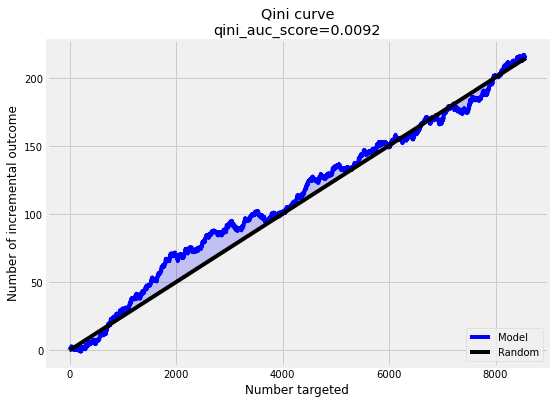

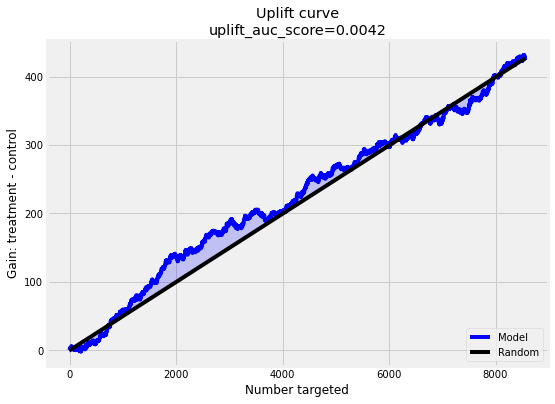

In [ ]:
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
# X learner
plot_qini_curve(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid, perfect=False)
plot_uplift_curve(y_true=y_valid, uplift=predict_my_xlrn, treatment=w_valid, perfect=False)

<AxesSubplot:title={'center':'Uplift curve\nuplift_auc_score=0.0138'}, xlabel='Number targeted', ylabel='Gain: treatment - control'>

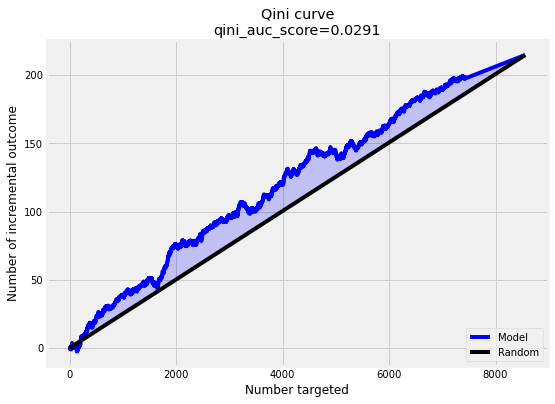

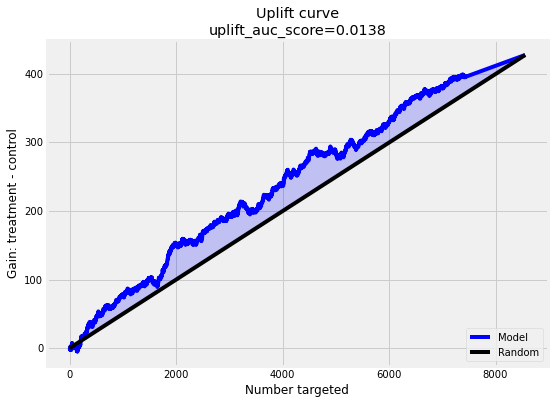

In [ ]:
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
# X learner
plot_qini_curve(y_true=y_valid, uplift=predict_my_rlrn, treatment=w_valid, perfect=False)
plot_uplift_curve(y_true=y_valid, uplift=predict_my_rlrn, treatment=w_valid, perfect=False)